In [41]:
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
from IPython.display import Image

import fileio
import time_utils

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46451 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


## Observations

In [20]:
agcd_file = '/g/data/xv83/dbi599/ag/pr_agcd_1900-2020_A-DEC-mean_wheat-sheep-mean.zarr.zip'
agcd_ds = fileio.open_file(agcd_file)

In [21]:
agcd_ds['pr'] = agcd_ds['pr'] * 365
agcd_ds['pr'].attrs['units'] = 'mm yr-1'

In [22]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)

agcd_df['south-west'] = agcd_ds['pr'].sel(region='south-west').values
agcd_df['south-east'] = agcd_ds['pr'].sel(region='south-east').values
agcd_df['north-east'] = agcd_ds['pr'].sel(region='north-east').values
agcd_df['all'] = agcd_ds['pr'].sel(region='all').values

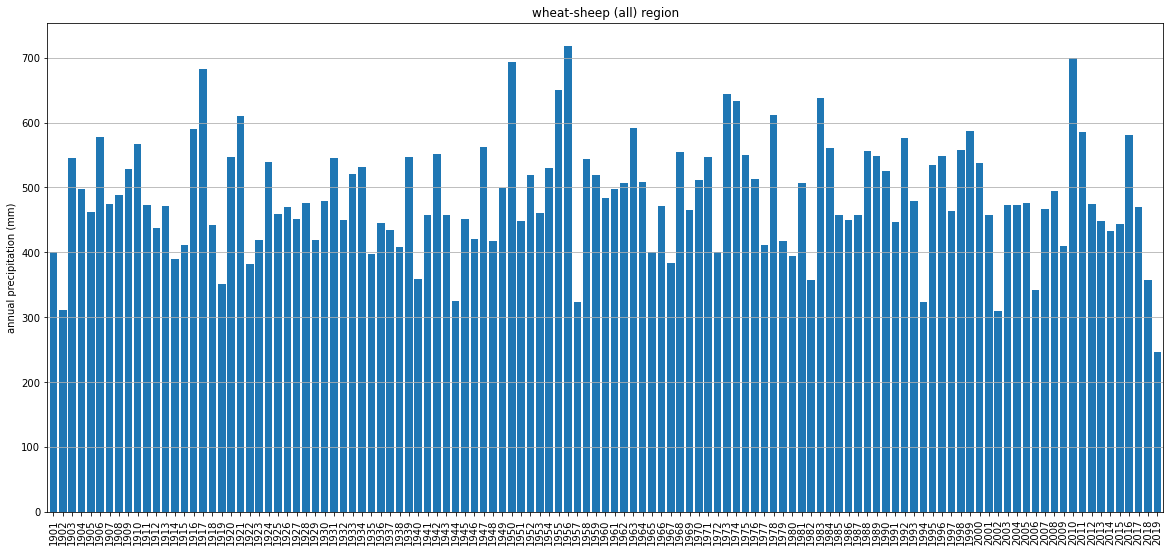

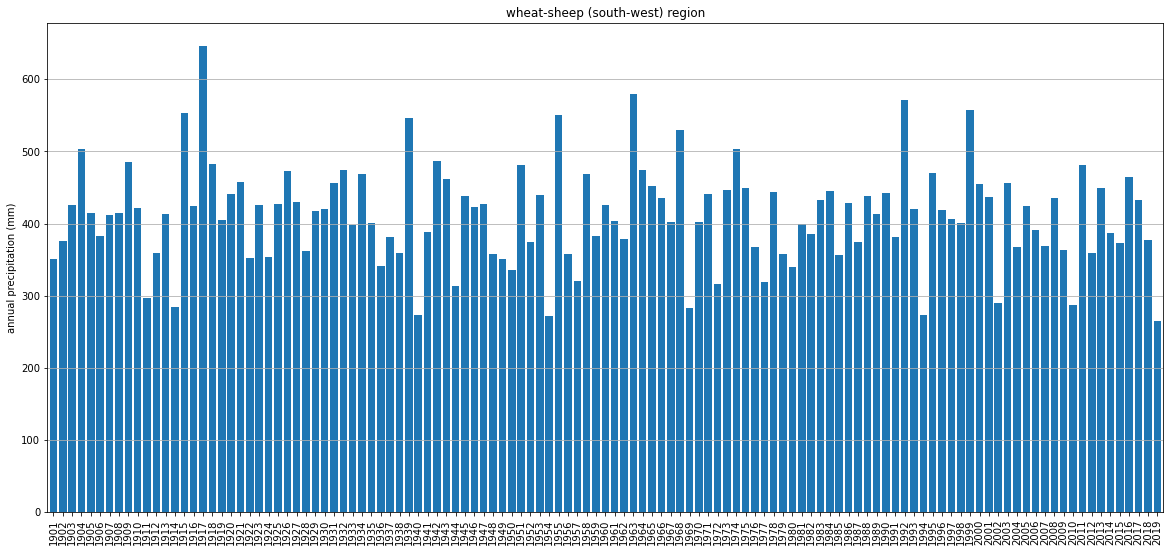

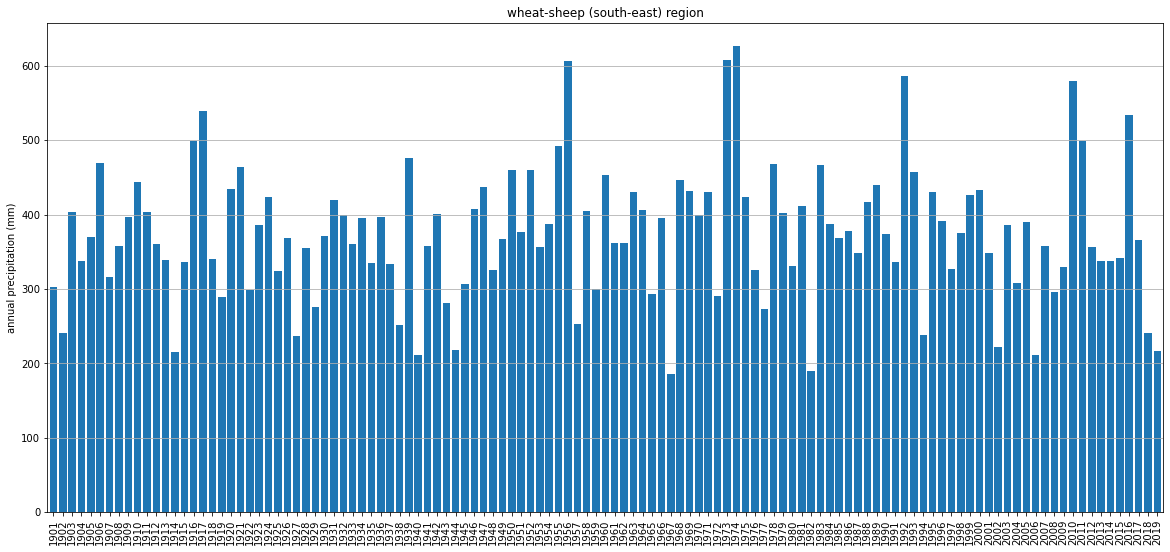

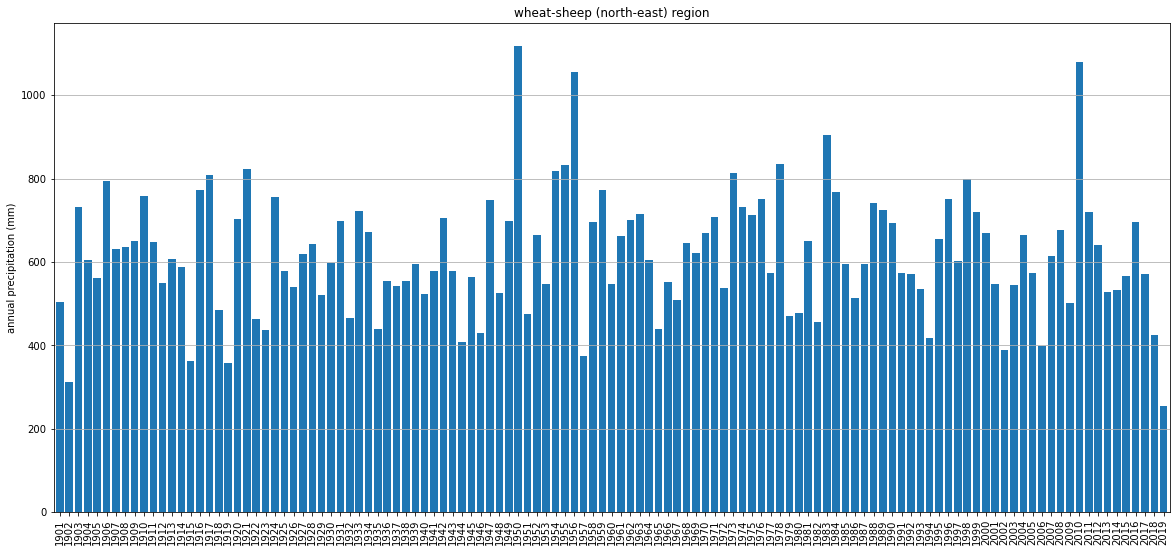

In [23]:
for region in ['all', 'south-west', 'south-east', 'north-east']:
    agcd_df[region].plot.bar(figsize=[20, 9], width=0.8)
    plt.ylabel('annual precipitation (mm)')
    plt.title(f'wheat-sheep ({region}) region')
    plt.grid(axis='y')
    plt.savefig(f'/g/data/xv83/dbi599/ag/wheat_sheep_precip_{region}.png', bbox_inches='tight', facecolor='white')
    plt.show()

In [24]:
ranked_years = agcd_df['all'].sort_values()
ranked_years.head(n=10)

2019    246.779661
2002    310.594415
1902    311.070922
1994    323.246636
1957    323.559183
1944    325.085380
2006    342.297344
1919    351.863862
2018    357.549319
1982    357.924929
Name: all, dtype: float64

2019 statistics from observational record: 1 in 119 year event (i.e. 0.8% percentile, 119 year return period)

2006 statistics from observational record: 7 in 119 year event (i.e. 5.9% percentile, 17 year return period)

## Model ensemble

In [25]:
cafe_file = '/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-mean_wheat-sheep-mean.zarr.zip'
cafe_bc_file = '/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-mean_wheat-sheep-mean_bias-corrected-awap-additive.zarr.zip'

In [26]:
cafe_ds = fileio.open_file(cafe_file)
cafe_bc_ds = fileio.open_file(cafe_bc_file)

In [27]:
cafe_bc_ds['pr'].attrs['units']

'mm d-1'

In [28]:
cafe_ds['pr'] = cafe_ds['pr'] * 365
cafe_ds['pr'].attrs['units'] = 'mm yr-1'

cafe_bc_ds['pr'] = cafe_bc_ds['pr'] * 365
cafe_bc_ds['pr'].attrs['units'] = 'mm yr-1'

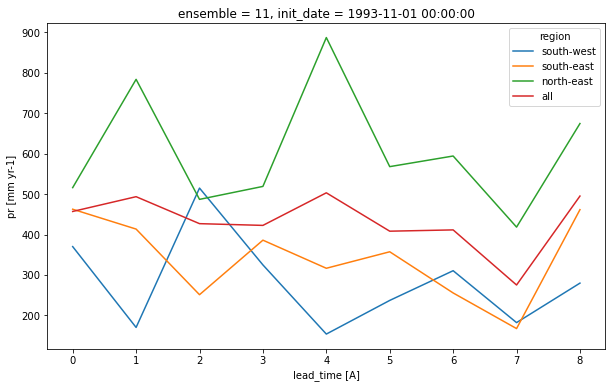

In [29]:
fig = plt.figure(figsize=[10, 6])

cafe_ds.isel(ensemble=10, init_date=5)['pr'].plot(hue='region')

plt.show()

## Bias correction and fidelity testing

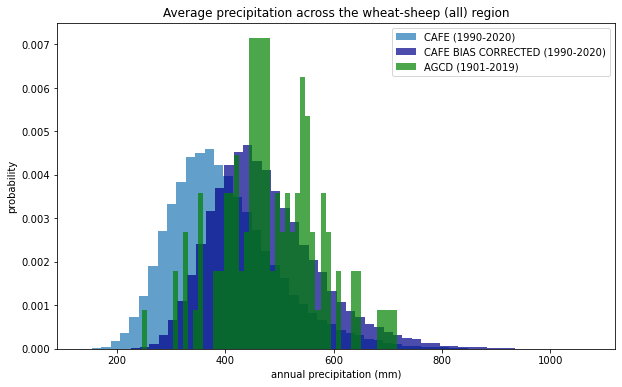

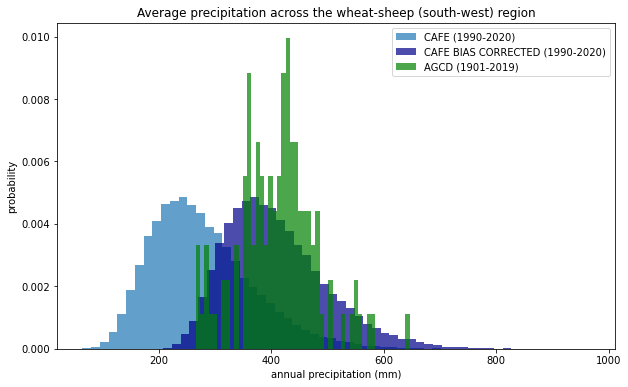

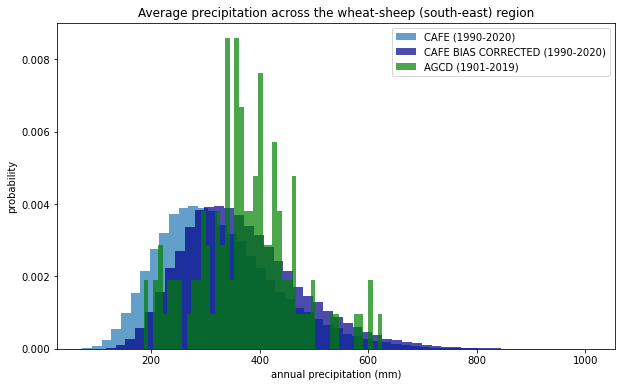

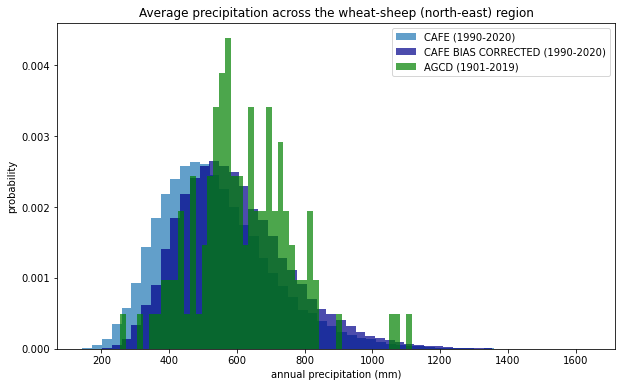

In [30]:
for region in ['all', 'south-west', 'south-east', 'north-east']:
    fig = plt.figure(figsize=[10, 6])
    cafe_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE (1990-2020)', alpha=0.7)
    cafe_bc_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED (1990-2020)', facecolor='darkblue', alpha=0.7)
    agcd_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='AGCD (1901-2019)', facecolor='green', alpha=0.7)
    plt.xlabel('annual precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Average precipitation across the wheat-sheep ({region}) region')
    plt.legend()
    #plt.savefig(f'/g/data/xv83/dbi599/wheat_sheep_precip_histogram_{region}.png', bbox_inches='tight', facecolor='white')
    plt.show()

In [31]:
fidelity_file = '/g/data/xv83/dbi599/ag/ks-test_pr_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip'

In [32]:
fidelity_ds = xr.open_zarr(fidelity_file)

In [33]:
fidelity_ds.sel(region='all')['pval'].values

array([0.19772346, 0.23290606, 0.32697679, 0.23919983, 0.1702512 ,
       0.13978759, 0.13506761, 0.11797867, 0.10130883])

p > 0.05 at all lead times so the null hypothesis (that the two samples are from the same population) can't be rejected.

## Independence testing

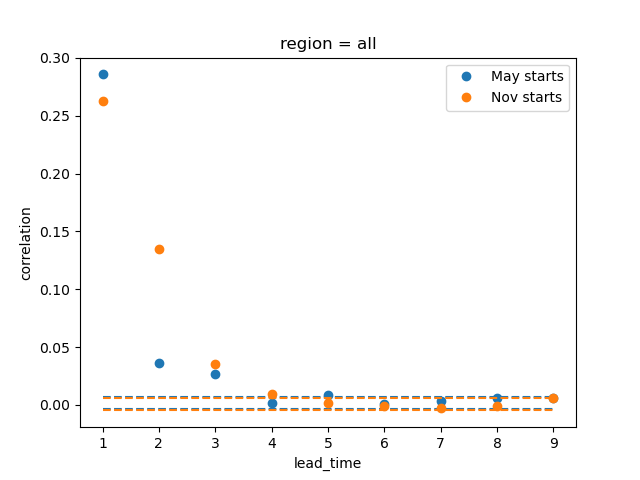

In [42]:
Image(filename='/g/data/xv83/dbi599/ag/independence-test_pr_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive_region-all.png')

## Exceedance curves

In [37]:
cafe_bc_ds_stacked = cafe_bc_ds.sel(region='all', lead_time=slice(3, None))['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [39]:
96 * 62 * 6

35712

In [40]:
cafe_bc_ds_stacked.shape

(35712,)

In [43]:
def calc_exceedance(ds_stacked):
    """Calculate exceedance"""
    
    data = ds_stacked.compute()
    sorted_data = np.sort(data, axis=None)
    exceedance = 1.-np.arange(1.,len(data) + 1.)/len(data)
    
    return sorted_data, exceedance

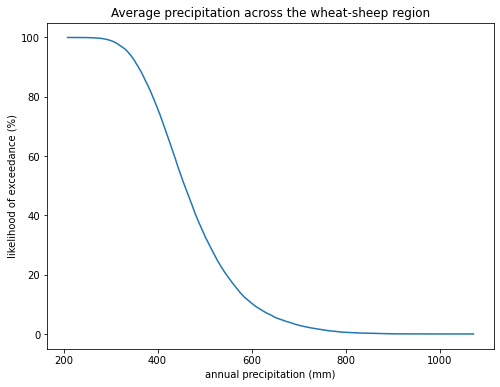

In [44]:
sorted_data, exceedance = calc_exceedance(cafe_bc_ds_stacked)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance * 100)
ax.set_title('Average precipitation across the wheat-sheep region')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
plt.show()

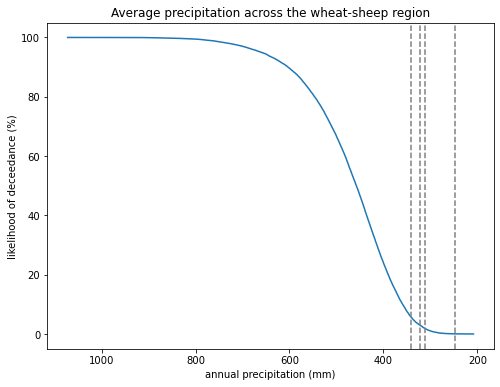

In [45]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, 100 - (exceedance * 100))
ax.invert_xaxis()
ax.set_title('Average precipitation across the wheat-sheep region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
#ax.plot(244.0081797, 0, 'o')
ax.axvline(246.779661, color='0.5', linestyle='--')
ax.axvline(310.594415, color='0.5', linestyle='--')
ax.axvline(323.246636, color='0.5', linestyle='--')
ax.axvline(342.297344, color='0.5', linestyle='--')
plt.show()

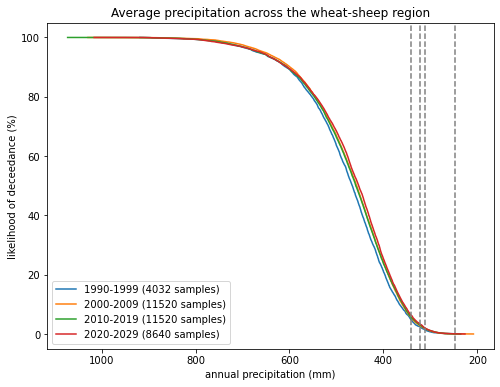

In [46]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

for start_year in [1990, 2000, 2010, 2020]:
    end_year = start_year + 9
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    ds_selection = time_utils.select_time_period(cafe_bc_ds_stacked, [start_date, end_date])
    ds_selection = ds_selection.dropna('sample')
    sorted_data, exceedance = calc_exceedance(ds_selection)
    n_years = len(sorted_data)
    label = f'{start_year}-{end_year} ({n_years} samples)'
    ax.plot(sorted_data, 100 - (exceedance * 100), label=label)

ax.invert_xaxis()
ax.set_title('Average precipitation across the wheat-sheep region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
ax.legend()
#ax.plot(244.0081797, 0, 'o')
ax.axvline(246.779661, color='0.5', linestyle='--')
ax.axvline(310.594415, color='0.5', linestyle='--')
ax.axvline(323.246636, color='0.5', linestyle='--')
ax.axvline(342.297344, color='0.5', linestyle='--')

plt.show()

In [47]:
def calc_likelihood(data, threshold, direction):
    """Calculate the likelihood of an event
    
    Args:
      data (np.ndarray)
      threshold (float)
      direction (str) : 'less' or 'greater' than
    """

    n_population = len(data)
    if direction == 'less':
        n_events = np.sum(data < threshold)
    elif direction == 'greater':
        n_events = np.sum(data > threshold)
    else:
        raise ValueError("""direction must be 'less' or 'greater'""")
        
    likelihood = (n_events / n_population) * 100
    
    return likelihood

In [48]:
wheat_import_years = [1994, 2002, 2006, 2019]

In [54]:
for year in wheat_import_years:
    slice_start = f'{year}-01-01'
    slice_end = f'{year}-12-31'
    threshold = float(agcd_ds['pr'].sel(time=slice(slice_start, slice_end), region='all').values)
    likelihood = calc_likelihood(cafe_bc_ds_stacked.values, threshold, 'less')
    return_period = 1 / (likelihood / 100)
    print(f'{year} ({threshold} mm): {likelihood}%, {return_period} years')

1994 (323.246635948967 mm): 3.052195340501792%, 32.763302752293576 years
2002 (310.5944147899352 mm): 1.7725134408602152%, 56.4170616113744 years
2006 (342.29734390455957 mm): 5.877576164874552%, 17.013816102906148 years
2019 (246.77966056566456 mm): 0.03640232974910394%, 2747.076923076923 years


TODO: Look at how these numbers change for each decade

In [55]:
np.count_nonzero(cafe_bc_ds_stacked.values < 246.779661)

13

In [57]:
(13 / 35712) * 100

0.03640232974910394

## Summary

2019 was an incredibly rare event (unpreceedented in the observational record, a one in 2700 year event in our large ensemble) but years sufficiently dry to require wheat imports (i.e. 2006 rainfall of 342mm) are relatively frequent (1 in 17 years in both the observational record and model ensemble).